# Autoencoders for Anomaly Detection

Based on the article at https://bit.ly/2VgNyl7, made for the bonus task of the cyber data analytics class. Download the data and adjust the paths in the next cells.

Requires 
* seaborn
* tensorflow
* keras
* sklearn
* pyplot, pylab

and for visualizing the network also the graphviz package. Install directly from the notebook with **!pip install package**

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

SEED = 123 
DATA_SPLIT_PCT = 0.2

LABELS = ["Normal","Attack"]

# please adjust the dataset paths
NORMAL = "../data/trn_set_1.csv"
MIXED = "../data/trn_set_2.csv"
TEST = "../data/test_set.csv"

In [31]:
df_normal =  pd.read_csv(NORMAL, skipinitialspace=True)
df_mixed = pd.read_csv(MIXED, skipinitialspace=True)
df_test = pd.read_csv(TEST, skipinitialspace=True)

Harmonize the labels across the datasets to 0 / 1

**WARNING**: THIS TREATS *unlabeled* DATA AS NORMAL, see https://batadal.net/images/rules.pdf for the documentation of the -999 value.


In [32]:
df_mixed.ATT_FLAG.replace([-999, 1], [0, 1], inplace=True)

Drop non-numeric columns, concatenate the dataframes.
We train the autoencoder on the normal data from BATADAL_dataset03 and test on BATADAL_dataset04

In [33]:
df_normal = df_normal.drop(['DATETIME'], axis=1)
df_mixed = df_mixed.drop(['DATETIME'], axis=1)
df_test = df_test.drop(['DATETIME'], axis=1)

#df = pd.concat([df_normal, df_mixed], ignore_index=True)

Splitting into training, validation, testing, group into classes

In [34]:
#df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
#df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)


df_train = df_normal
df_valid = df_mixed

In [35]:
df_train_0 = df_train.loc[df['ATT_FLAG'] == 0]
df_train_1 = df_train.loc[df['ATT_FLAG'] == 1]

df_train_0_x = df_train_0.drop(['ATT_FLAG'], axis=1)
df_train_1_x = df_train_1.drop(['ATT_FLAG'], axis=1)


df_valid_0 = df_valid.loc[df['ATT_FLAG'] == 0]
df_valid_1 = df_valid.loc[df['ATT_FLAG'] == 1]

df_valid_0_x = df_valid_0.drop(['ATT_FLAG'], axis=1)
df_valid_1_x = df_valid_1.drop(['ATT_FLAG'], axis=1)


#df_test_0 = df_test.loc[df['ATT_FLAG'] == 0]
#df_test_1 = df_test.loc[df['ATT_FLAG'] == 1]

#df_test_0_x = df_test_0.drop(['ATT_FLAG'], axis=1)
#df_test_1_x = df_test_1.drop(['ATT_FLAG'], axis=1)

Scale the data to 0-1 range

In [36]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['ATT_FLAG'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test)
#df_test_x_rescaled = scaler.transform(df_test.drop(['ATT_FLAG'], axis = 1))

C:\Users\biby_\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\biby_\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\biby_\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


## Train and Validate the network

We define a function for computing the confusion matrix based on a prediction and true labels.

In [62]:
def get_conf_mat_entry(results, true_attack, pred_attack):
    # just a helper function
    result = results[
        (results['true'] == (1 if true_attack else 0)) 
        & 
        (results['pred'] == (1 if pred_attack else 0))
    ]
    #print(result.shape[0])
    return result.shape[0]

We define a function for training (on the training set 1) and validating (on the training set 2) a given architecture.

In [64]:
def train_validate_architecture(autoencoder, nb_epoch, batch_size, lr, beta):
    
    #Train
    autoencoder.compile(metrics=['accuracy'],
                        loss='mean_squared_error',
                        optimizer='adam')

    cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                        verbose=0,
                        callbacks=[cp, tb]).history

    
    #Validate
    valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
    mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse,
                            'True_class': df_valid['ATT_FLAG'] == 1})

    precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
    
    f_beta = [((1+ beta**2)*prec*rec)/(beta**2 * prec + rec) for prec, rec in zip(precision_rt, recall_rt)]
    best_threshold = threshold_rt[np.argmax(f_beta)]
    
    final_detection = error_df.Reconstruction_error > best_threshold
    res = pd.concat([error_df.True_class.astype(int), final_detection.astype(int)], axis=1)
    res.columns = ['true', 'pred']
    res.set_index(final_detection.index)

    t_p = get_conf_mat_entry(res, true_attack=True, pred_attack=True)
    t_n = get_conf_mat_entry(res, true_attack=False, pred_attack=False)
    f_p = get_conf_mat_entry(res, true_attack=False, pred_attack=True)
    f_n = get_conf_mat_entry(res, true_attack=True, pred_attack=False)
    
    
    plt.figure(figsize=(17, 3))
    plt.plot(error_df.Reconstruction_error, color = 'green', label = 'error')
    plt.plot(list(np.array([best_threshold for _ in range(error_df.shape[0])])), color = 'red', label = 'threshold')
    plt.yscale('log')
    plt.legend()
    plt.title('Reconstruction Error')
    plt.show()
    
    plt.figure(figsize=(17, 3))
    plt.title(f'Detection using {epochs} epochs, {lr} learning rate')
    plt.plot(error_df.True_class, color = 'red', label = 'True class')
    plt.plot(final_detection, color = 'green', label='Detection', alpha=0.3)
    plt.legend()
    plt.show() 
    
    print(f"TP {t_p}, TN {t_n}, FP {f_p}, FN {f_n}") 
    
    return np.max(f_beta), best_threshold

## Set up a neural network with relu-encoder

We perform Grid Search on the number of epochs and the learning rate using F0.25 and F3 in order to determine the best threshold for performing the anomaly detection.

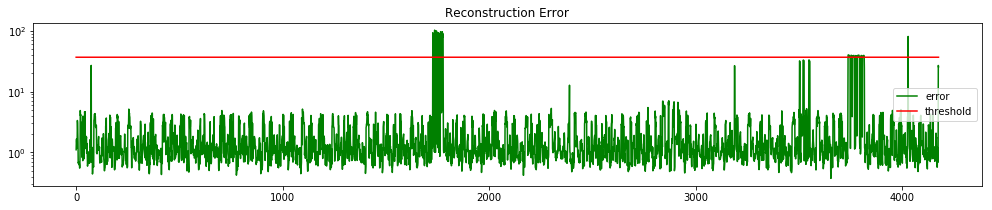

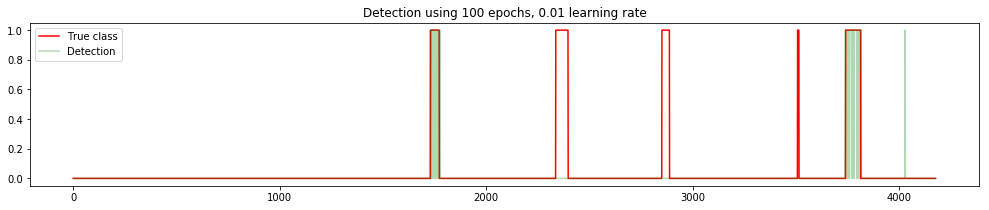

TP 82, TN 3944, FP 14, FN 137
Number of epochs 100, learning rate 0.01, resulting F0.25 0.7967250141163186 and threshold 36.68758356673384


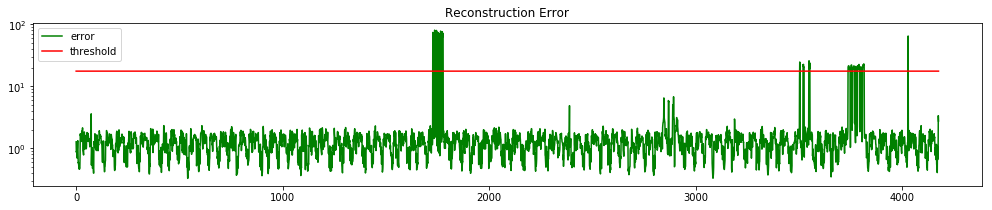

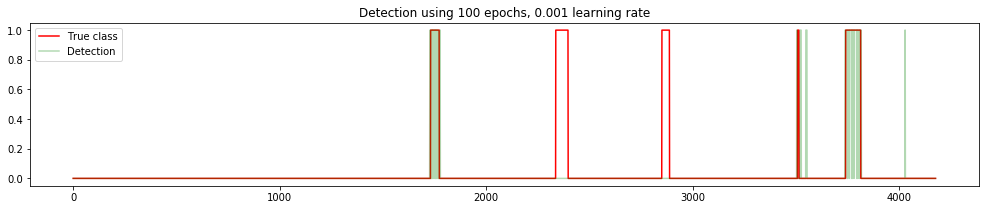

TP 82, TN 3930, FP 28, FN 137
Number of epochs 100, learning rate 0.001, resulting F0.25 0.7072681704260653 and threshold 17.577764767797564


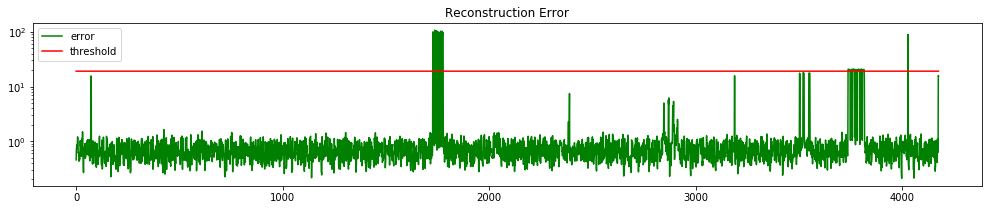

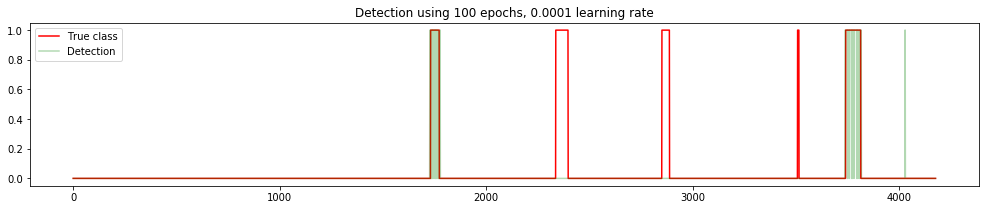

TP 82, TN 3944, FP 14, FN 137
Number of epochs 100, learning rate 0.0001, resulting F0.25 0.7967250141163186 and threshold 19.097205799064113


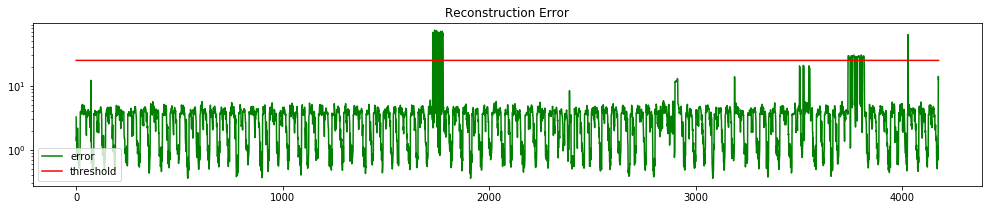

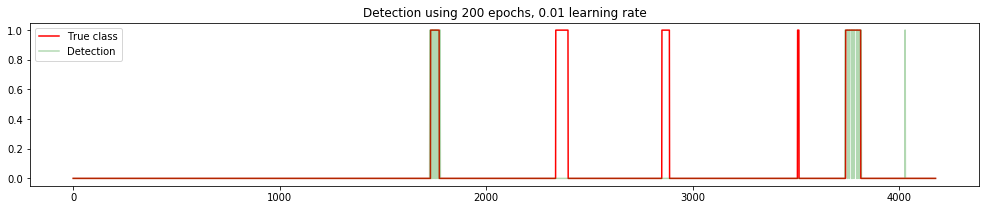

TP 82, TN 3944, FP 14, FN 137
Number of epochs 200, learning rate 0.01, resulting F0.25 0.7967250141163186 and threshold 24.969504623221717


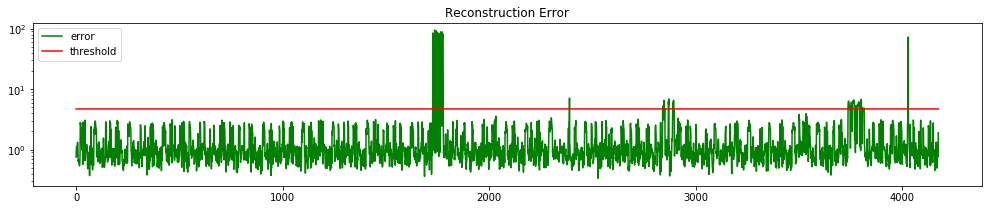

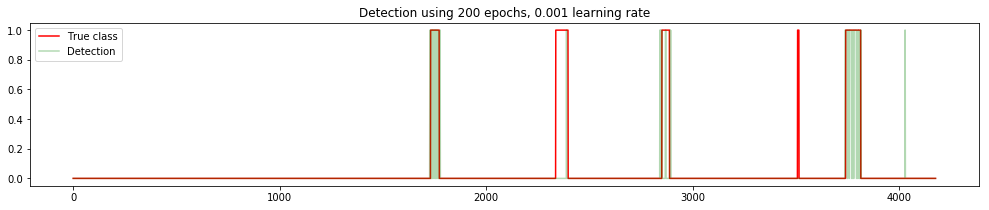

TP 72, TN 3939, FP 19, FN 147
Number of epochs 200, learning rate 0.001, resulting F0.25 0.7338852749852157 and threshold 4.7158928825672595


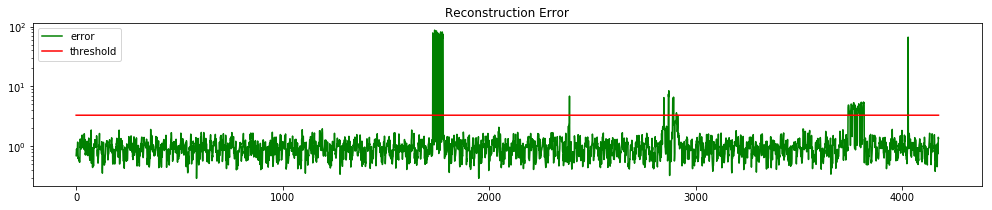

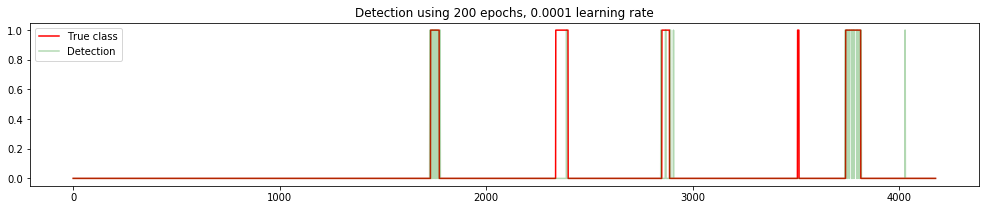

TP 83, TN 3938, FP 20, FN 136
Number of epochs 200, learning rate 0.0001, resulting F0.25 0.7583643122676581 and threshold 3.3111989320997144


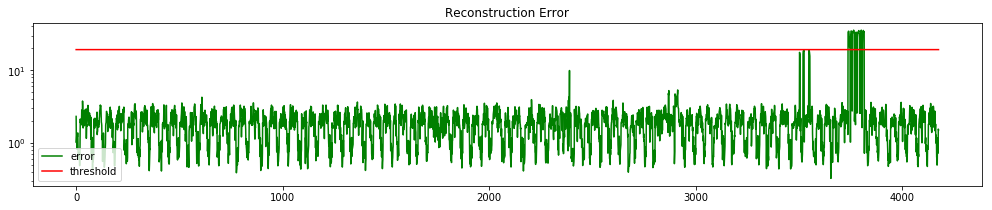

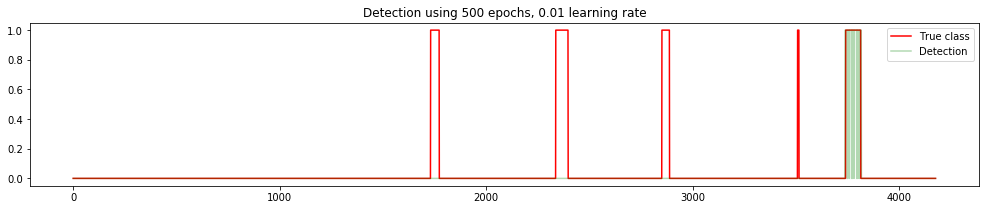

TP 58, TN 3952, FP 6, FN 161
Number of epochs 500, learning rate 0.01, resulting F0.25 0.7966640190627482 and threshold 19.224107690186685


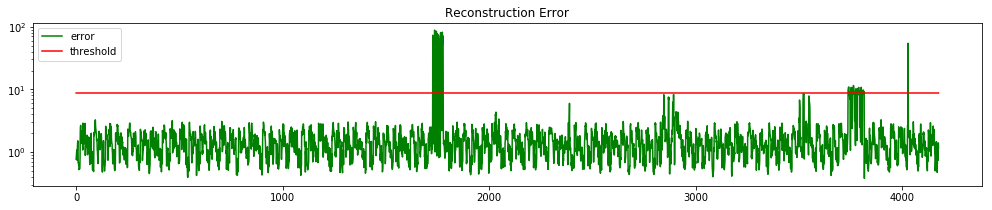

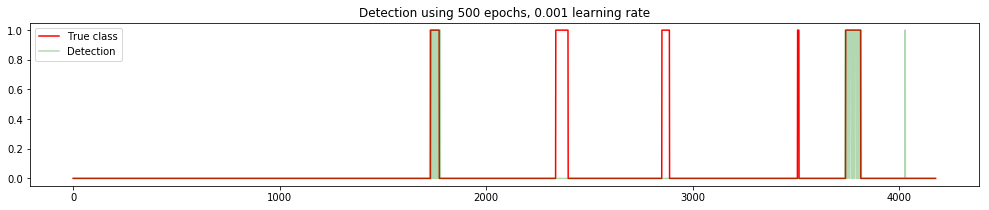

TP 65, TN 3946, FP 12, FN 154
Number of epochs 500, learning rate 0.001, resulting F0.25 0.7648261758691207 and threshold 8.758934574414072


C:\Users\biby_\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


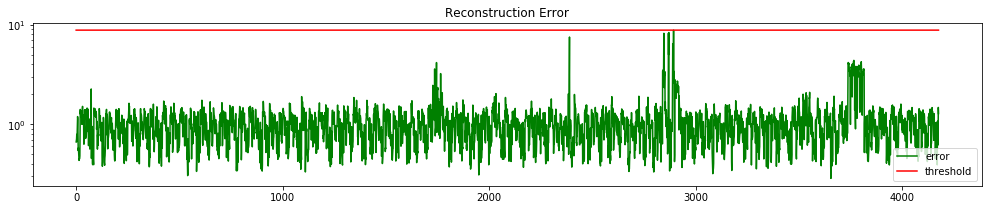

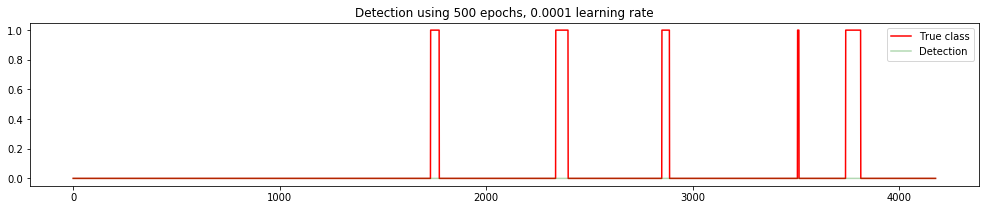

TP 0, TN 3958, FP 0, FN 219
Number of epochs 500, learning rate 0.0001, resulting F0.25 nan and threshold 8.840272307457665


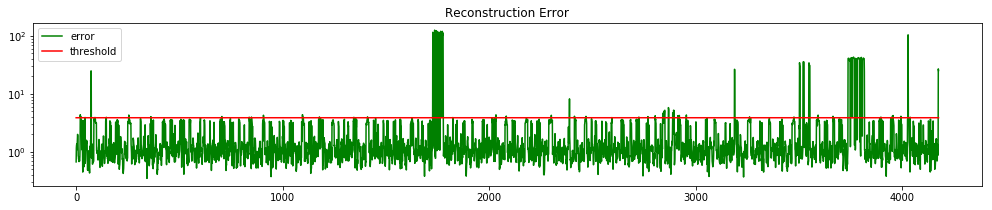

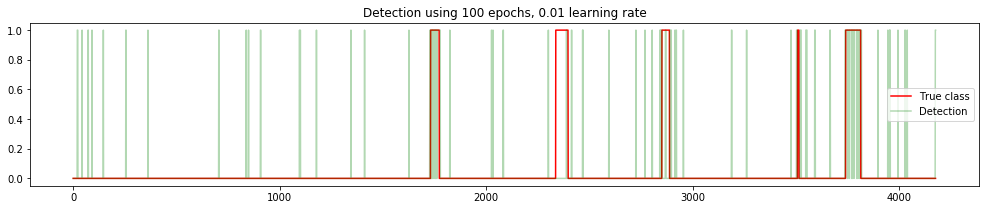

TP 93, TN 3856, FP 102, FN 126
Number of epochs 100, learning rate 0.01, resulting F3 0.43377941855099217 and threshold 3.8810389671487364


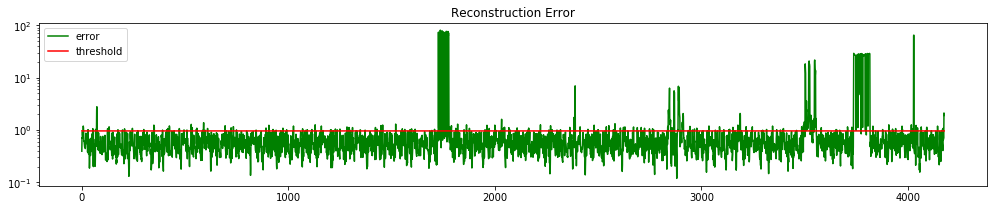

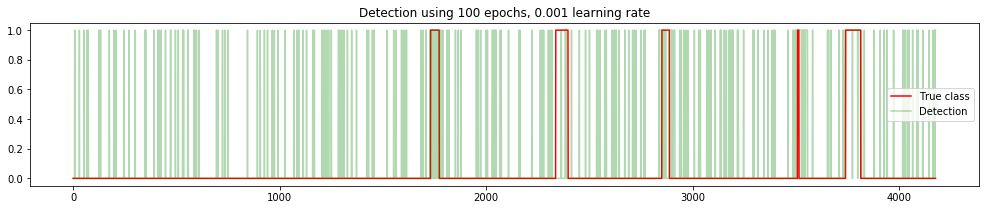

TP 120, TN 3646, FP 312, FN 99
Number of epochs 100, learning rate 0.001, resulting F3 0.5033277870216306 and threshold 0.9626830106528361


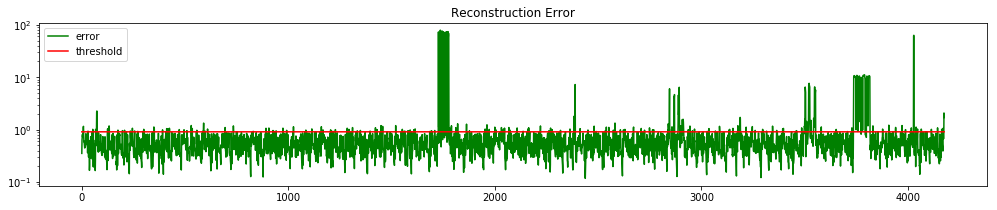

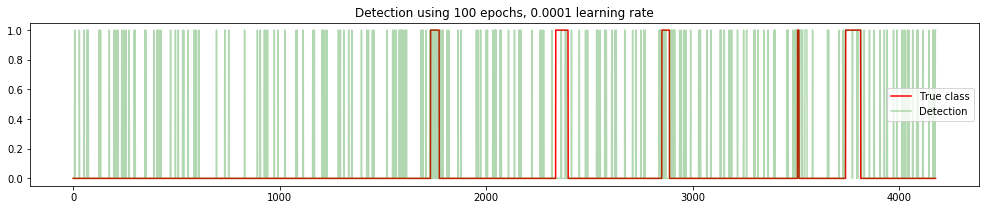

TP 114, TN 3672, FP 286, FN 105
Number of epochs 100, learning rate 0.0001, resulting F3 0.484822934232715 and threshold 0.909465850695463


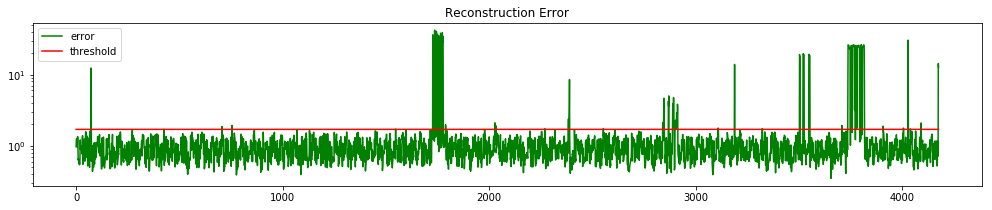

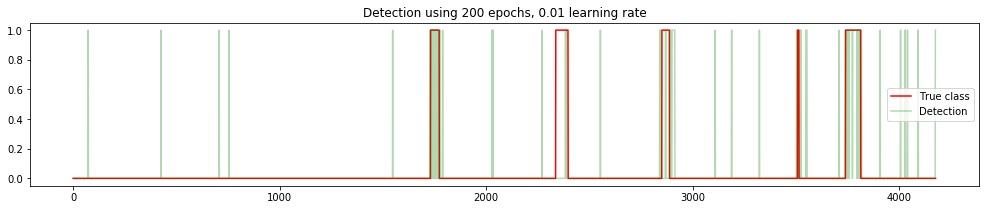

TP 95, TN 3873, FP 85, FN 124
Number of epochs 200, learning rate 0.01, resulting F3 0.4460966542750929 and threshold 1.7008656001727576


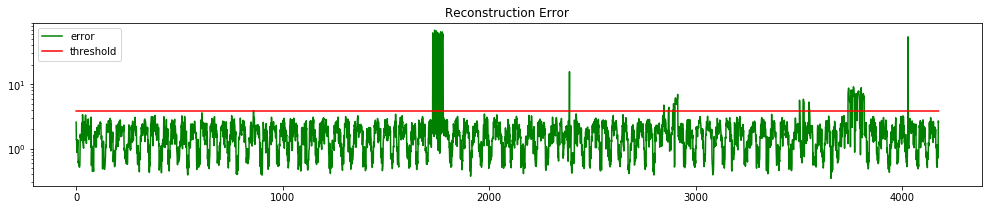

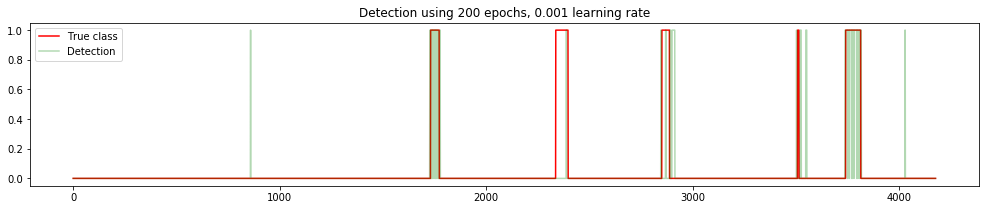

TP 87, TN 3914, FP 44, FN 132
Number of epochs 200, learning rate 0.001, resulting F3 0.4184498335710888 and threshold 3.8409439559715066


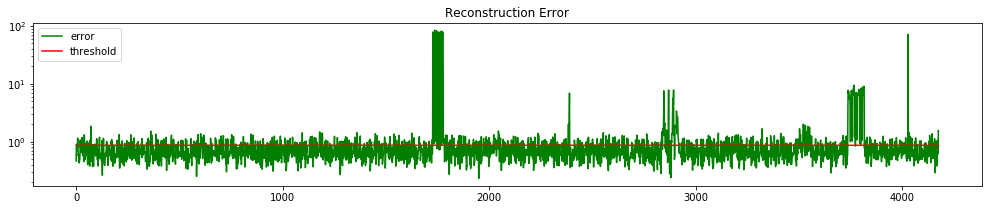

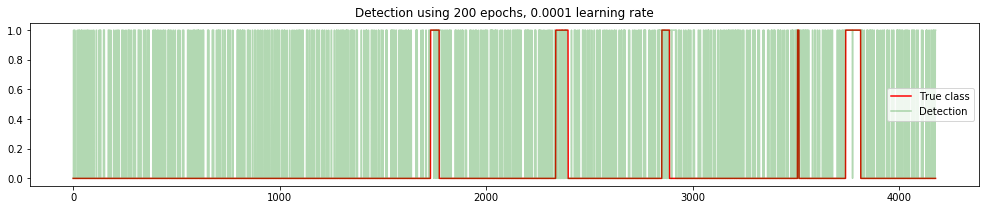

TP 147, TN 3085, FP 873, FN 72
Number of epochs 200, learning rate 0.0001, resulting F3 0.4946524064171123 and threshold 0.8627493138971917


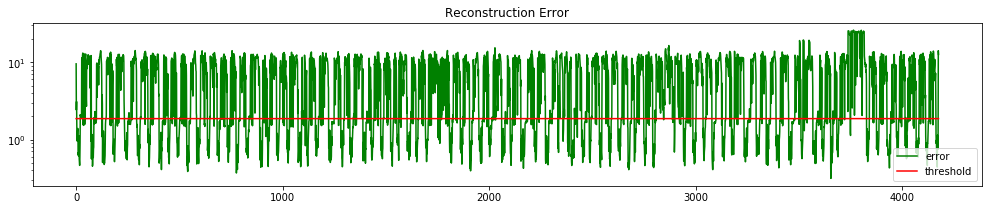

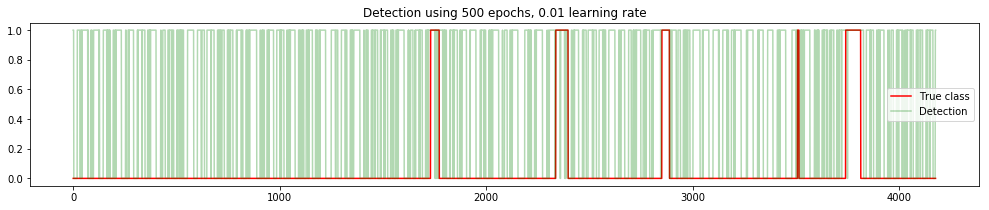

TP 195, TN 1670, FP 2288, FN 24
Number of epochs 500, learning rate 0.01, resulting F3 0.43995510662177334 and threshold 1.8652885492548308


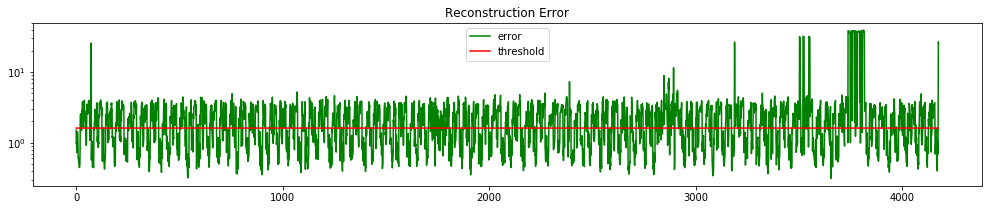

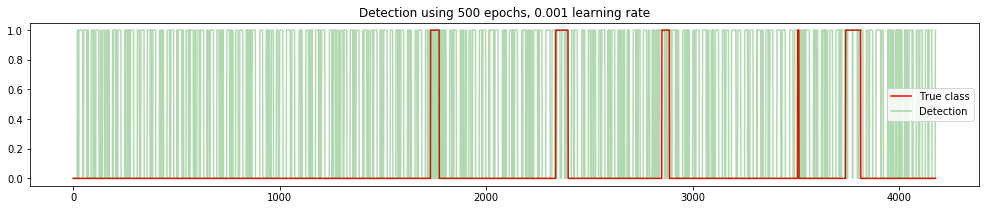

TP 167, TN 1860, FP 2098, FN 52
Number of epochs 500, learning rate 0.001, resulting F3 0.39650696247344813 and threshold 1.6117921939255362


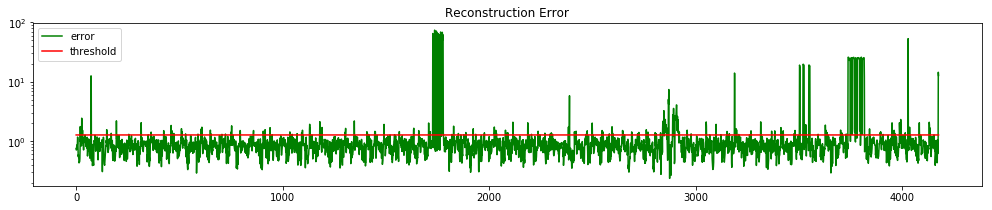

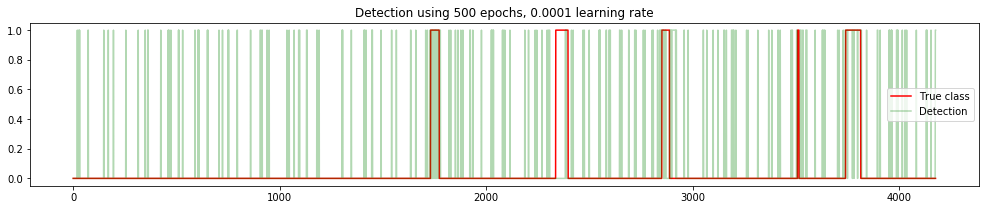

TP 111, TN 3695, FP 263, FN 108
Number of epochs 500, learning rate 0.0001, resulting F3 0.4774083546462063 and threshold 1.271386274416315


In [66]:
nb_epoch = [100, 200, 500]
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 16
hidden_dim = int(encoding_dim / 2)
learning_rate = [1e-2, 1e-3, 1e-4]

for beta_value in [0.25, 3]:
    for epochs in nb_epoch:
        for lr in learning_rate:

            input_layer = Input(shape=(input_dim, ))
            encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(lr))(input_layer)
            encoder = Dense(hidden_dim, activation="relu")(encoder)
            decoder = Dense(hidden_dim, activation='tanh')(encoder)
            decoder = Dense(input_dim, activation='relu')(decoder)
            autoencoder = Model(inputs=input_layer, outputs=decoder)


            f_beta, threshold = train_validate_architecture(autoencoder, epochs, batch_size, lr, beta_value)

            print(f"Number of epochs {epochs}, learning rate {lr}, resulting F{beta_value} {f_beta} and threshold {threshold}")

## Evaluate on testing

We are performing the evaluation detection based on the threshold determined using the F3 score. The dataset used for the evaluation is the test set for which we do not have the labels. Below we plot the detected attacks, the reconstruction error and the threshold for detecting the attacks.

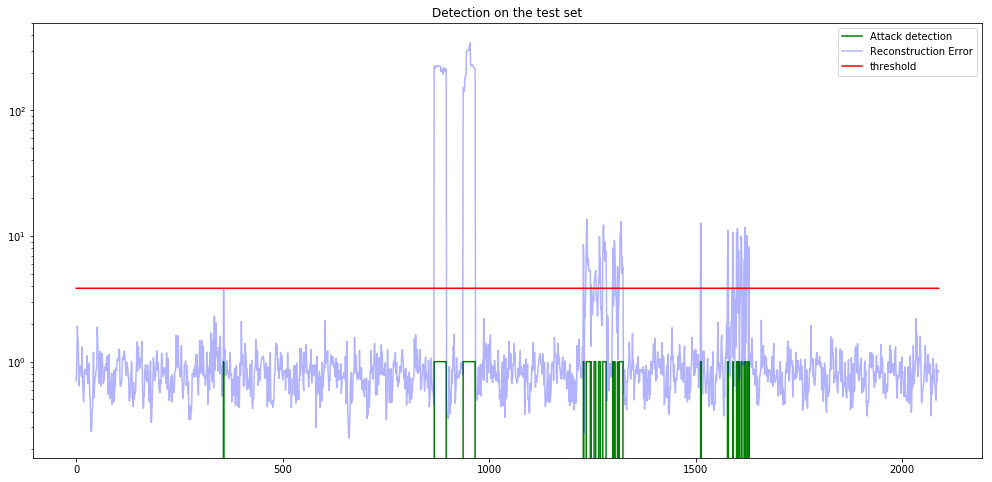

In [83]:
threshold_fixed = 3.841


test_x_predictions = autoencoder.predict(df_test_0_x_rescaled)

mse = np.mean(np.power(df_test_0_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse})
error_df_test = error_df_test.reset_index()


plt.figure(figsize=(17, 8))
plt.title(f'Detection on the test set')
plt.plot(error_df_test.Reconstruction_error > threshold_fixed, color = 'green', label = 'Attack detection')
plt.plot(error_df_test.Reconstruction_error, color = 'blue', label = 'Reconstruction Error', alpha = 0.3)
plt.plot(list(np.array([threshold_fixed for _ in range(error_df_test.shape[0])])), color = 'red', label = 'threshold')
plt.yscale('log')
plt.legend()
plt.show()
